## Orange | French Telecom Company | Customer Churn Prediction | InClass Kaggle Competition

In [102]:
# Importing required packages

# Data exploration
import matplotlib.pyplot           as plt

# Data Processing
import pickle
import numpy                       as np
import pandas                      as pd
from sklearn.impute                import SimpleImputer
from sklearn.preprocessing         import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing         import MinMaxScaler
from sklearn.feature_selection     import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection     import SelectFromModel
from sklearn.decomposition         import PCA

# Modeling
from sklearn.linear_model          import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier
from sklearn.ensemble              import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm                   import LinearSVC
from sklearn.neural_network        import MLPClassifier
import xgboost                     as xgb
from sklearn.linear_model          import LogisticRegression
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier
from sklearn.ensemble              import GradientBoostingClassifier
from sklearn.svm                   import SVC
from sklearn.neural_network        import MLPClassifier
from sklearn.neighbors             import KNeighborsClassifier

# Evaluation
from sklearn.metrics               import accuracy_score
from sklearn.metrics               import auc
from sklearn.metrics               import roc_auc_score
from sklearn.metrics               import roc_curve
from sklearn.metrics               import confusion_matrix
from ieseg                         import partition
from ieseg                         import roc
from ieseg                         import lift
from ieseg                         import cumulativeResponse
from ieseg                         import cumulativeGains
from pandas                        import DataFrame
from pandas                        import read_csv
from pandas                        import Series
from numpy                         import array
from numpy                         import random

# Experimental setup
from sklearn.model_selection       import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling        import SMOTE, RandomOverSampler
from imblearn.combine              import SMOTETomek
from imblearn.pipeline             import Pipeline
from sklearn.metrics               import roc_auc_score
from sklearn.model_selection       import learning_curve

In [103]:
# Version

exp_version = 'v5'   # Experiment version
data_prep   = 'full' # full = data transformation, representation;  std = standard, only dummy encode
var_set     = 'fs'   # all = all vars; fs = top fisher score; pca = first PCs
fname       = '_' + data_prep + '_' + var_set + '_' + exp_version  # Name of output file

print(fname)

_full_fs_v5


In [104]:
# Flag variables to run the data processing steps

# Value Transformation Steps
enable_trans_cat_dt = True  # Remapping cat variables    - Decision tree–based remapping
enable_trans_num_dt = True  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = True  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = True  # Discretizing num variables - Equal width discretization

# Value Representation Steps
enable_repr_dummy   = True   # Represent cat variables - Dummy coding
enable_repr_icd     = True  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe     = False  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars       = True   # Drop cat variables after value representation step

# Other Data Processing Step
enable_normalize = True      # Normalize the data to the same range [0, 1]

## 1. Data Summary

### 1.a) Read & Check the data

In [105]:
# Reading the data

train = pd.read_csv('orange_churn_train.csv', low_memory=False)
test  = pd.read_csv('orange_churn_test.csv', low_memory=False)

In [106]:
# Checking the train dataset

train.head(3)

,cust_id,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,churn
0,3,NaN,NaN,NaN,NaN,NaN,1351.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,7P5s,ZI9m,NoEd,mj86,NaN,0
1,4,NaN,NaN,NaN,NaN,NaN,644.0,0.0,NaN,NaN,...,76DJixu,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,7,NaN,NaN,NaN,NaN,NaN,2583.0,0.0,NaN,NaN,...,I5dzv5f,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,1


In [107]:
# Checking the info of train dataset

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 232 entries, cust_id to churn
dtypes: float64(191), int64(3), object(38)
memory usage: 17.7+ MB


### 1.b) Create a list of column names to manage variables

In [108]:
# List of numerical and catergorical variables

id_var   = ["cust_id"]                      # ID
num_vars = train.columns[1:191].tolist()    # Numerical Variables   (First 190 vars)
cat_vars = train.columns[191:231].tolist()  # Categorical Variables (Last 40 vars)

# Target get variable
target_var = ["churn"]

### 1.c) Check the target variable class distribution

In [109]:
# By number
print(train["churn"].value_counts())

# By percentage
print(train["churn"].value_counts(normalize=True))

0    9264
1     736
Name: churn, dtype: int64
0    0.9264
1    0.0736
Name: churn, dtype: float64


- There are totally **93% Non-Churners** & only **7% Churners** in the dataset
- Hence the class is heavily imbalanced

## 2. Data Processing

### 2.1 Data & Error Correction

#### 2.1.a) Constant Variables - Data & Error Correction

Constant variables on train do not contain information and may cause data processing or model training error.

In [110]:
# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)   # Counts unique value
cont_vars    = vars_nunique.index[vars_nunique < 2].tolist()                               # Contains only 1 unique value
print("Drop constant variable:", cont_vars)

# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars] # Adding variable names to num_vars only if it is not in cont_vars
cat_vars = [v for v in cat_vars if v not in cont_vars] # Adding variable names to cat_vars only if it is not in cont_vars

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test  = test[ id_var + num_vars + cat_vars]

Drop constant variable: ['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48', 'Var52', 'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175', 'Var185', 'Var209', 'Var230']


#### 2.1.b) Missing Values - Data & Error Correction

<u>Note:</u>
- Always create indicators (dummy variable) to track the missing values imputation.
- Since we already filtered out the constant NA vars, the imputor will not drop any vars.

In [111]:
# Check missing value

print('Train - #NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - #NA of cat vars:', train[cat_vars].isna().sum().sum())
print('--------------------------------')
print('Test  - #NA of num vars:', test[num_vars].isna().sum().sum())
print('Test  - #NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - #NA of num vars: 1345535
Train - #NA of cat vars: 79067
--------------------------------
Test  - #NA of num vars: 1345234
Test  - #NA of cat vars: 79296


In [112]:
# List dummary variables to track missing values imputation
na_vars = []

In [113]:
# Numerical variables

# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[num_vars])

# Reconstruct the list of vars + indicators
na_vars     = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars

# Apply on train, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)
test[impute_vars]  = pd.DataFrame(imp.transform(test[num_vars]),  columns=impute_vars)

In [114]:
# Categorical variables

# Impute missing value using a new category "Missing"
# Note: If the categorical vars are imputed by most_frequent, the indicators should be added
train[cat_vars] = train[cat_vars].fillna('Missing')
test[cat_vars]  = test[cat_vars].fillna('Missing')

#### 2.1.c) Outliers in Numerical Variables - Data & Error Correction

Here, we only check but not impute the outliers.

<u>Note:</u>
- Before correcting outliers, make sure to understand the nature of the error.
- No need to correct outliers for missing values indicators.

In [115]:
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(train[v])
    sd = np.std(train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (train[v] < lower) | (train[v] > upper)
    test_out = (test[v] < lower) | (test[v] > upper)
    if np.sum(train_out) + np.sum(test_out) > 0:
        print(v, "has # outliers on train, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]",
              np.sum(test_out), "[", np.round(100*np.mean(test_out), 2), "% ]")

Var1 has # outliers on train, test : 21 [ 0.21 % ] 21 [ 0.21 % ]
Var3 has # outliers on train, test : 12 [ 0.12 % ] 3 [ 0.03 % ]
Var4 has # outliers on train, test : 2 [ 0.02 % ] 3 [ 0.03 % ]
Var5 has # outliers on train, test : 27 [ 0.27 % ] 29 [ 0.29 % ]
Var6 has # outliers on train, test : 85 [ 0.85 % ] 85 [ 0.85 % ]
Var7 has # outliers on train, test : 214 [ 2.14 % ] 190 [ 1.9 % ]
Var9 has # outliers on train, test : 66 [ 0.66 % ] 76 [ 0.76 % ]
Var10 has # outliers on train, test : 37 [ 0.37 % ] 32 [ 0.32 % ]
Var11 has # outliers on train, test : 18 [ 0.18 % ] 14 [ 0.14 % ]
Var12 has # outliers on train, test : 75 [ 0.75 % ] 81 [ 0.81 % ]
Var13 has # outliers on train, test : 85 [ 0.85 % ] 72 [ 0.72 % ]
Var14 has # outliers on train, test : 14 [ 0.14 % ] 11 [ 0.11 % ]
Var16 has # outliers on train, test : 200 [ 2.0 % ] 174 [ 1.74 % ]
Var17 has # outliers on train, test : 32 [ 0.32 % ] 37 [ 0.37 % ]
Var18 has # outliers on train, test : 12 [ 0.12 % ] 18 [ 0.18 % ]
Var19 has # outlie

#### 2.1.d) Encode Categorical Variables - Data & Error Correction

In Python, most of the machine learning libraries cannot handle non-numerical values in the categorical varibales (e.g. Random Forest). Therefore, we should encode the categories using integer values.

<u>Note:</u>
- Ordinal Encoder is a method where we encode the categories while preserving it's natural order (e.g. Low, High, Very High)
- Here, the encoder is fitted on both train and test.
- Therefore, in a few special cases, there are unique categories that appear only on train, or test.

In [116]:
# Encode categorical variables as integer values
# Note: All the NA values were imputed previously
enc = OrdinalEncoder()
enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))

# Apply on train, test
train[cat_vars] = enc.transform(train[cat_vars])
test[cat_vars] = enc.transform(test[cat_vars])

#### 2.1.e) Finalize the processed data

Current lists of variables:
- id_var     : customer ID
- num_vars   : numerical variables
- cat_vars   : categorical variables
- na_vars    : indicators for tracking missing values, bool [False, True]
- target_var : target variable, churn [0, 1]

<u>Note:</u> If there are any variables exist in only train or test, drop them from all the data.

In [117]:
# Convert bool variables to int

train[na_vars] = train[na_vars].astype(np.int8)
test[na_vars]  = test[na_vars].astype(np.int8)

In [118]:
# Print out the final variables

print("# id_var     [", len(id_var),     "] :", id_var)
print("# num_vars   [", len(num_vars),   "] :", num_vars[:5], "...")
print("# cat_vars   [", len(cat_vars),   "] :", cat_vars[:5], "...")
print("# na_vars    [", len(na_vars),    "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var     [ 1 ] : ['cust_id']
# num_vars   [ 174 ] : ['Var1', 'Var2', 'Var3', 'Var4', 'Var5'] ...
# cat_vars   [ 38 ] : ['Var191', 'Var192', 'Var193', 'Var194', 'Var195'] ...
# na_vars    [ 171 ] : ['Var1_na', 'Var2_na', 'Var3_na', 'Var4_na', 'Var5_na'] ...
# target_var [ 1 ] : ['churn']


In [119]:
# Sort the data according to the variables list

train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test  = test[ id_var + num_vars + cat_vars + na_vars]

print(train.shape)
print(test.shape)

(10000, 385)
(10000, 384)


### 2.2 Feature engineering

Since every variables are anonymized, we cannot create new variables based the meaning of current variables.

In other case, we can use the following hints:
- Quickly check the potentially important variables.
- Focus on the most important variables to create new variables.
- Create a cross variable framework (e.g. customer activities, date-time, events, etc.) for searching the new variables.

#### 2.2.a) Quickly detect most important varriables - Correlation test for numerical variables

In [120]:
# Pearson's correlation for numerical variables

corr = train[num_vars + target_var].corr(method='pearson')
corr = corr['churn'][:-1].dropna()

print("Top 5 vars [+] correlated with target var :"); print(corr.sort_values(ascending=False)[:5])
print("-------------------------------------------")
print("Top 5 vars [-] correlated with target var :"); print(corr.sort_values(ascending=True)[:5])

Top 5 vars [+] correlated with target var :
Var113    0.054660
Var131    0.033685
Var126    0.030609
Var173    0.029983
Var81     0.028262
Name: churn, dtype: float64
-------------------------------------------
Top 5 vars [-] correlated with target var :
Var189   -0.087654
Var73    -0.073407
Var7     -0.059302
Var65    -0.047361
Var13    -0.039086
Name: churn, dtype: float64


#### 2.2.b) Quickly detect most important varriables - Mutual information a.k.a Information Gain

In [121]:
# Check mutual information for all variables
# Note: Calculation involves a random process, therefore the result may change if there is no variable with significant info.

mutual_info = mutual_info_classif(train[cat_vars], train[target_var].values.squeeze())
mutual_info = pd.Series(mutual_info, index=cat_vars)
print("Top 10 vars :"); print(mutual_info.sort_values(ascending=False)[:10])

Top 10 vars :
Var217    0.006262
Var212    0.006072
Var218    0.006070
Var192    0.005885
Var193    0.005805
Var207    0.005312
Var210    0.004683
Var205    0.004486
Var223    0.004176
Var224    0.004098
dtype: float64


### 2.3 Value Transformation (num, cat => cat)

- Categorical variable: Remapping
- Continuous variable : Discretization

<u>Note:</u> Some techniques that incoporate the information from target variable may cause overfitting problem.

In [122]:
# List of variables to track the value transformation process
trans_vars = []

#### 2.3.1) Remapping categorical variables - Decision tree–based remapping

#### 2.3.1.a) Test the variable remmaping on a categorical variable

In [123]:
# Select a variable
v = "Var217"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])

print("Best AUC        :", clf.best_score_)
print("Best params     :", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC        : 0.53261613050796
Best params     : {'min_samples_leaf': 1000}
Number of leaves: 9


In [124]:
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original categories    :", train[[v]].nunique().values[0])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original categories    : 5367
# new remapped categories: 9 {2, 4, 5, 7, 10, 11, 14, 15, 16}


#### 2.3.1.b) Apply the variable remmaping for all categorical variables

<u>Note:</u> Only remap the variables if AUC > 0.5 and the number of new categories > 1.

In [125]:
if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", train[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Remapping variable Var192 from 286 to 14 categories
Remapping variable Var193 from 40 to 5 categories
Remapping variable Var194 from 4 to 2 categories
Remapping variable Var195 from 20 to 3 categories
Remapping variable Var197 from 187 to 11 categories
Remapping variable Var198 from 2019 to 14 categories
Remapping variable Var199 from 1769 to 3 categories
Remapping variable Var200 from 4397 to 4 categories
Remapping variable Var201 from 3 to 2 categories
Remapping variable Var202 from 3771 to 16 categories
Remapping variable Var203 from 6 to 3 categories
Remapping variable Var204 from 100 to 53 categories
Remapping variable Var205 from 4 to 4 categories
Remapping variable Var206 from 22 to 8 categories
Remapping variable Var207 from 13 to 3 categories
Remapping variable Var208 from 3 to 2 categories
Remapping variable Var210 from 6 to 2 categories
Remapping variable Var211 from 2 to 2 categories
Remapping variable Var212 from 68 to 3 categories
Remapping variable Var213 from 2 to 2 cat

#### 2.3.2) Discretizing (or Binning) numerical variables - Decision tree–based discretization

#### 2.3.2.a) Test the variable discretizing on a numerical variable

In [126]:
# Select a variable
v = "Var6"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.5589419285653838
Best params: {'min_samples_leaf': 1000}
Number of leaves: 7


In [127]:
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original data range: ", [train[[v]].min().values[0], train[[v]].max().values[0]])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original data range:  [0.0, 114079.0]
# new remapped categories: 7 {3, 4, 6, 8, 9, 11, 12}


#### 2.3.2.b) Apply the variable discretizing for all numerical variables

<u>Note:</u> Only bin/discretize the variables if the number of new categories > 1.

In [128]:
if enable_trans_num_dt:
    for v in num_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Discretize variable", v,
                  "from", [train[[v]].min().values[0], train[[v]].max().values[0]],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_bin'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Discretize variable Var3 from [0.0, 13752.0] to 2 categories
Discretize variable Var4 from [0.0, 9.0] to 2 categories
Discretize variable Var6 from [0.0, 114079.0] to 7 categories
Discretize variable Var7 from [0.0, 35.0] to 4 categories
Discretize variable Var11 from [8.0, 32.0] to 2 categories
Discretize variable Var13 from [0.0, 197872.0] to 11 categories
Discretize variable Var14 from [0.0, 34.0] to 2 categories
Discretize variable Var17 from [0.0, 240.0] to 2 categories
Discretize variable Var18 from [0.0, 948.0] to 2 categories
Discretize variable Var19 from [0.0, 9.0] to 2 categories
Discretize variable Var21 from [0.0, 36272.0] to 6 categories
Discretize variable Var22 from [0.0, 45340.0] to 6 categories
Discretize variable Var24 from [0.0, 494.0] to 5 categories
Discretize variable Var25 from [0.0, 13168.0] to 3 categories
Discretize variable Var28 from [-33.52, 1537.76] to 12 categories
Discretize variable Var34 from [0.0, 24.0] to 2 categories
Discretize variable Var35 from 

#### 2.3.3) Discretizing (or Binning) numerical variables - Equal frequency discretization

#### 2.3.3.a) Test the variable discretizing on a numerical variable

In [129]:
# Select a variable
v = "Var38"

# Binning values of a variable into new groups using equal frequency approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
est.fit(train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 9
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


array([array([0.0000000e+00, 1.3056000e+03, 6.3534600e+04, 5.4795360e+05,
       2.0273880e+06, 2.5428557e+06, 3.5213070e+06, 4.8254844e+06,
       6.7276680e+06, 1.7127060e+07])], dtype=object)

In [130]:
# Apply the binning to a variable
binef_v = est.transform(train[[v]])
pd.value_counts(pd.DataFrame(binef_v).values.flatten()).sort_index()

0.0    2000
1.0    1000
2.0    1000
3.0    1000
4.0     326
5.0    1674
6.0    1000
7.0    1000
8.0    1000
dtype: int64

#### 2.3.3.b) Apply the variable discretizing for all numerical variables

In [131]:
if enable_trans_num_ef:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binef_var = v + '_binef'
            trans_vars.append(binef_var)
            train[binef_var] = est.transform(train[[v]])
            test[binef_var] = est.transform(test[[v]])

the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 

#### 2.3.4) Discretizing (or Binning) numerical variables - Equal width discretization

#### 2.3.4.a) Test the variable discretizing on a numerical variable

In [132]:
# Select a variable
v = "Var38"

# Binning values of a variable into new groups using equal width approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
est.fit(train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10


array([array([       0.,  1712706.,  3425412.,  5138118.,  6850824.,  8563530.,
       10276236., 11988942., 13701648., 15414354., 17127060.])],
      dtype=object)

In [133]:
# Apply the binning to a variable
binew_v = est.transform(train[[v]])
pd.value_counts(pd.DataFrame(binew_v).values.flatten()).sort_index()

0.0    4811
1.0    2127
2.0    1253
3.0     870
4.0     479
5.0     280
6.0     156
7.0      13
8.0       7
9.0       4
dtype: int64

#### 2.3.4.b) Apply the variable discretizing for all numerical variables

In [134]:
if enable_trans_num_ew:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binew_var = v + '_binew'
            trans_vars.append(binew_var)
            train[binew_var] = est.transform(train[[v]])
            test[binew_var] = est.transform(test[[v]])

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "


#### 2.3.5. Finalize Value Transformation

- Finalize the variables list
- Arrange the data columns

<u>Note:</u> After the end of the value transformation step, we have these final lists of variables to manage:
- num_vars
- na_vars
- cat_vars = cat_vars + trans_vars

In [135]:
# Finalize the variable list
cat_vars = cat_vars + trans_vars

print("Transformed num, cat variables into # new categorical variables :", len(trans_vars))

Transformed num, cat variables into # new categorical variables : 473


In [136]:
# Arrange the data columns

train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test  = test[ id_var + num_vars + cat_vars + na_vars]

print(train.shape)
print(test.shape)

(10000, 858)
(10000, 857)


### 2.4. Value Representation (cat => num)

- Categorical variable: Dummy coding
- Categorical variable: Incidence replacement
- Categorical variable: Weight of Evidence (WoE) conversion

In [137]:
# List of variables to track the value representation process

repr_vars  = []
dummy_vars = []

#### 2.4.1. Dummy Encoding

<u>Note:</u> Here, we can fit the encoder on both train and test to make sure it captures all unique categories.

#### 2.4.1.a) Test the value representation on a categorical variable

In [138]:
# Select a variable
v = "Var194"

# Build the dummy encoding on [Var194]
enc = OneHotEncoder(drop="first", handle_unknown="error")
enc.fit(pd.concat([train[[v]], test[[v]]], axis=0))
enc.categories_

[array([0., 1., 2., 3.])]

In [139]:
# Transform a categorical variable

dummy_v = enc.transform(train[[v]])
dummy_v.toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

#### 2.4.1.b) Apply the value representation for all categorical variables

In [140]:
if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, test
    train_dummy = enc.transform(train[cat_vars])
    test_dummy = enc.transform(test[cat_vars])

#### 2.4.2. Incidence (of target variable) replacement

#### 2.4.2.a) Test the value representation on a categorical variable

In [141]:
# Select a variable
v = "Var194"

# Find the incidence rates per category of a categorical variable
tb         = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
tb.columns = [v, v + "_icd"]
tb

,Var194,Var194_icd
0,0.0,0.000000
1,1.0,0.076882
2,2.0,0.065063
3,3.0,0.000000


In [142]:
# Add/join the incidence variable

pd.merge(train[[v]], tb, on=v).head()

,Var194,Var194_icd
0,1.0,0.076882
1,1.0,0.076882
2,1.0,0.076882
3,1.0,0.076882
4,1.0,0.076882


#### 2.4.2.b) Apply the value representation for all categorical variables

In [143]:
if enable_repr_icd:
    for v in cat_vars:
        # Find the incidence rates per category of a categorical variable
        tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
        icd_var = v + "_icd"
        repr_vars.append(icd_var)
        tb.columns = [v, icd_var]
        # Add the incidence column to train, test
        train[icd_var] = pd.merge(train[[v]], tb, on=v)[icd_var]
        test[icd_var] = pd.merge(test[[v]], tb, on=v)[icd_var]

#### 2.4.4. Finalize Value Representation 

#### 2.4.4.a) Drop categorical variables, add dummy variables

At the end of this step, all categorical variables were represented by dummy variables or numerical variables. Therefore, it is no need to keep categorical variables.

In [147]:
# Drop cat vars
if drop_cat_vars:
    train = train.drop(cat_vars, axis=1)
    test = test.drop(cat_vars, axis=1)
    cat_vars = []

In [148]:
# Add dummy variables
if enable_repr_dummy:
    train = pd.concat([train, pd.DataFrame(train_dummy.toarray(), columns=dummy_vars)], axis=1)
    test = pd.concat([test, pd.DataFrame(test_dummy.toarray(), columns=dummy_vars)], axis=1)
    del train_dummy, test_dummy

#### 2.4.4.b) Impute missing values created by value representation

During the value representation process, if the categorical variables have new categories on test, the represented values might be missing on test data. Therefore, it is necessary to correct again here.

In [149]:
# Impute new missing values on test using the mean on train
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[repr_vars])
test[repr_vars] = pd.DataFrame(imp.transform(test[repr_vars]), columns=repr_vars)

#### 2.4.4.c) Finalize the variables list

<u>Note:</u> At the end of the value representation step, we have these final lists of variables to manage:
- num_vars = num_vars + repr_vars
- na_vars

In [150]:
# Combine the variable list
num_vars = num_vars + repr_vars

print("Represented cat variables with # new numerical variables :", len(repr_vars))

Represented cat variables with # new numerical variables : 44985


In [151]:
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test  = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(10000, 45332)
(10000, 45331)


### 2.5. Other data processing

#### 2.5.a) Data normalization - Numerical variables

<u>Note:</u>
- It is not necessary to normalize dummy variables since they are in [0, 1].
- With large data set, calling MinMaxScaler().fit() may cause memory issue.

In [152]:
if enable_normalize:
    for v in num_vars:
        # Build the normalizer on train
        scaler = MinMaxScaler().fit(train[[v]])
        # Apply on train, test
        train[v] = scaler.transform(train[[v]])
        test[v] = scaler.transform(test[[v]])

####  2.5.b) Filter out low variance variables (or constant)

During the data processing, we may accidentally create some new constant variables. Therefore, it is necessary to filter again.

In [153]:
# List of all predictors

predictors = num_vars + cat_vars + na_vars

In [154]:
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, test
print('Drop # constant vars :', len(const_vars))
train = train.drop(const_vars, axis=1)
test = test.drop(const_vars, axis=1)

Drop # constant vars : 14938


#### 2.5.c) Drop duplicated variables

Sometime, the data processing process can create a lot of duplicated variables. In this case, it is necessary to identify and drop them.

In [155]:
# Count the duplicated vars

dup_vars = train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 15008


In [156]:
# Drop the duplicated vars from train, test

predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
train = train[id_var + predictors + target_var]
test = test[id_var + predictors]

#### 2.5.d) Export the processed data to file

In [157]:
# Print out the data to check

print(train.shape)
print(test.shape)

(10000, 15386)
(10000, 15385)


### 2.6. Variable Selection

In [160]:
# Create several lists to handle variables

id_var     = ['cust_id']
target_var = ['churn']
predictors = [v for v in train.columns if v not in id_var + target_var]

####  2.6.a) Variable selection: Fisher Score

In [161]:
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

In [162]:
# Calculate Fisher Score for all variable

fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

,predictor,fisherscore
13788,x130_25,0.271954
15382,Var126_na,0.271197
14116,x280_4.0,0.269831
14679,x451_3.0,0.233952
168,Var189,0.230800


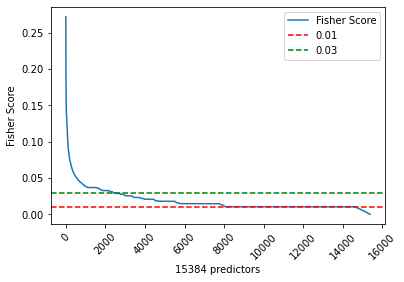

In [163]:
# Visualize the Fisher Score

plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axhline(y=0.01, linestyle='dashed', color='red')
plt.axhline(y=0.03, linestyle='dashed', color='green')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', '0.01', '0.03'])
plt.show()

In [165]:
# Select the top variables based on Fisher Score
# top_fs_vars = fs_df[fs_df['fisherscore'] >= 0.03]['predictor'].values

top_fs_vars = fs_df['predictor'].values[:50]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 50


array(['x130_25', 'Var126_na', 'x280_4.0', 'x451_3.0', 'Var189', 'Var73',
       'x56_3', 'x20_31.0', 'x130_22', 'x25_3007.0', 'x69_5', 'x36_8.0',
       'x39_5', 'x451_2.0', 'x229_9.0', 'x14_3.0', 'x2_22.0', 'Var7',
       'x26_2.0', 'x33_1.0', 'x64_9', 'x59_24', 'x63_5', 'Var113',
       'x73_11', 'x451_1.0', 'x16_10.0', 'x52_4', 'x58_3', 'x280_1.0',
       'x35_2.0', 'x29_4.0', 'x45_3', 'x43_20', 'x9_3049.0', 'x103_6',
       'x509_2.0', 'x56_4', 'x230_4.0', 'x98_6', 'x439_5.0', 'x102_6',
       'x103_4', 'Var65', 'x114_18', 'x138_3', 'Var13', 'x29_6.0',
       'x7_1924.0', 'x130_4'], dtype=object)

In [166]:
# Converting the Top 50 Fisher values from NumPy array to list 

top_fs_vars = top_fs_vars.tolist()

In [167]:
# Selecting the Top 50 predictors for the train and test dataset

predictors = top_fs_vars
train      = train[id_var + predictors + target_var]
test       = test[id_var + predictors]

#### 2.6.a.1) Export the processed data to file

In [168]:
# Print out the data to check

print(train.shape)
print(test.shape)

(10000, 52)
(10000, 51)


In [169]:
# Save to pickle format

train.to_pickle("train_processed" + fname + ".pkl")
test.to_pickle ("test_processed"  + fname + ".pkl")

## 3. Modeling

In [174]:
# Create several lists to handle variables for both train & test dataset

id_var     = ['cust_id']
target_var = ['churn']
predictors = [v for v in train.columns if v not in id_var + target_var]

In [175]:
# Selecting the Features & Target Variables

features_train = predictors
features_test  = predictors
target_train   = target_var

In [176]:
# Defining Training & Testing Dataset

TrainingSet = train
TestSet     = test

In [177]:
# Instanciating the Models

tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True) 
neighbors    = KNeighborsClassifier()
neuralNet    = MLPClassifier()

In [178]:
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         } 

In [179]:
for model in models:
    models[model].fit(TrainingSet[features_train],TrainingSet[target_train])
    print(f"{model} has been trained successfully")

tree has been trained successfully
logistic has been trained successfully
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
<ipython-input-179-eead3439b38f>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  models[model].fit(TrainingSet[features_train],TrainingSet[target_train])
randomForest has been trained successfully
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
boostedTree has been trained successfully
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarn

### 3.1) Model Performance & Evaluation (Using Accuracy Score, Confusion Martix and AUC)

#### 3.1.a) Performance of the Train Dataset

In [181]:
performances_train = {}

for model in models:
    predictions   = models[model].predict(TrainingSet[features_train])
    probabilities = DataFrame(models[model].predict_proba(TrainingSet[features_train]))[1]
    accuracy      = accuracy_score(TrainingSet[target_train],predictions)
    auc           = roc_auc_score(array(TrainingSet[target_train]),array(probabilities))
    
    performances_train[model] = {"Accuracy":accuracy,"AUC":auc,"Probabilities":probabilities}

In [182]:
# Confusion Matrix for Training Set

CM_Train = confusion_matrix(TrainingSet[target_train], predictions)
CM_Train

array([[9231,   33],
       [ 679,   57]], dtype=int64)

In [183]:
# Performance of Training Set on Model
DataFrame(performances_train)

,tree,logistic,randomForest,boostedTree,svm,neuralNet,neighbors
Accuracy,0.9999,0.9257,0.9999,0.9307,0.9264,0.94,0.9288
AUC,1,0.751147,1,0.806884,0.852345,0.89588,0.90792
Probabilities,0 0.0 1 0.0 2 1.0 3 0....,0 0.018891 1 0.075063 2 0.31...,0 0.00 1 0.14 2 0.74 3 ...,0 0.028630 1 0.075438 2 0.45...,0 0.058612 1 0.077148 2 0.07...,0 0.000792 1 0.107311 2 0.50...,0 0.0 1 0.2 2 0.6 3 0....


#### 3.1.b) Performance of the Test DataSet

In [185]:
performances_test = {}

for model in models:
    predictions   = models[model].predict(TestSet[features_test])
    probabilities = DataFrame(models[model].predict_proba(TestSet[features_test]))[1]
    
    performances_test[model] = {"Probabilities":probabilities}

In [186]:
# Performance of Testing Set on our Model
DataFrame(performances_test)

,tree,logistic,randomForest,boostedTree,svm,neuralNet,neighbors
Probabilities,0 1.0 1 0.0 2 0.0 3 1....,0 0.320510 1 0.159201 2 0.10...,0 0.70 1 0.14 2 0.01 3 ...,0 0.247913 1 0.096965 2 0.05...,0 0.076945 1 0.076687 2 0.06...,0 0.282810 1 0.124531 2 0.01...,0 0.4 1 0.4 2 0.0 3 0....


## 4. Experimental Set-Up

### 4.a) K-Fold Validation

In [187]:
X = TrainingSet.iloc[:, 0: -1].values
y = TrainingSet.iloc[:, -1].values

kf = KFold(n_splits=10)

for train_indices, test_indices in kf.split(X):
    neuralNet.fit(X[train_indices], y[train_indices])
    print(neuralNet.score(X[test_indices], y[test_indices]))

0.838
0.789
0.926
0.933
0.915
0.921
0.921
0.933
0.912
0.931


### 4.b) Resampling (Handling heavily imbalanced target variable)

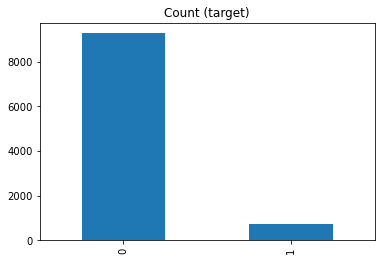

In [188]:
# Viusalizing the Class Imabalance

X = TrainingSet.iloc[:, 0: -1].values
y = TrainingSet.iloc[:, -1].values

df = pd.DataFrame(X)
df['churn'] = y
df.churn.value_counts().plot(kind='bar', title='Count (target)');

In [189]:
# Creating a function to visualize the sampling

def plot_2d_space(X, y, label='Classes'):
    """
    Returns a 2D plot of Sampling Result
    """   
    
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

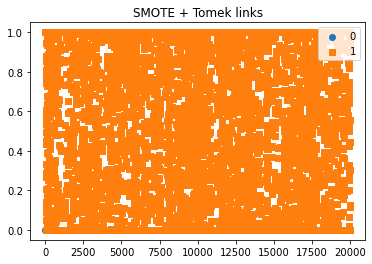

In [190]:
# Over-Sampling followed by Under-Sampling

# First, we are randomly creating duplicate examples of churners
# Next, we are randomly deleting examples of non-churners

smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_sample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

### 4.c) Machine Learning on Resampled Dataset

In [191]:
# Applying NeuralNet ML on the Resampled Dataset

# Converting NumPy array to Datafram
resampled_train          = pd.DataFrame(X_smt)
resampled_train['churn'] = y_smt

# Create several lists to handle variables for both train & test dataset
id_var_train     = [0]
id_var_test      = ['cust_id']
target_var       = ['churn']
predictors_train = [v for v in resampled_train.columns if v not in id_var_train + target_var]
predictors_test  = [v for v in TestSet.columns if v not in id_var_test + target_var]

# Selecting the Features & Target Variables
features_train = predictors_train
features_test  = predictors_test
target_train   = target_var

# Defining Training & Testing Dataset
TrainingSet = resampled_train
TestSet     = test

# Defining the model to be applied
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }  

# Training the Model
for model in models:
    models[model].fit(TrainingSet[features_train],TrainingSet[target_train])
    print(f"{model} has been trained successfully")

# Evaluating the performance
performances_train = {}
for model in models:
    predictions   = models[model].predict(TrainingSet[features_train])
    probabilities = DataFrame(models[model].predict_proba(TrainingSet[features_train]))[1]
    accuracy      = accuracy_score(TrainingSet[target_train],predictions)
    auc           = roc_auc_score(array(TrainingSet[target_train]),array(probabilities))
    
    performances_train[model] = {"Accuracy":accuracy,"AUC":auc,"Probabilities":probabilities}

tree has been trained successfully
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
logistic has been trained successfully
<ipython-input-191-f89c1f24dd28>:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  models[model].fit(TrainingSet[features_train],TrainingSet[target_train])
randomForest has been trained successfully
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
boostedTree has been trained successfully
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWar

In [192]:
# Performance of Training Set on Model
DataFrame(performances_train)

,tree,logistic,randomForest,boostedTree,svm,neuralNet,neighbors
Accuracy,0.99994,0.715643,0.99988,0.955513,0.906877,0.949441,0.933389
AUC,1,0.785439,1,0.980638,0.978088,0.989844,0.987939
Probabilities,0 0.0 1 0.0 2 1.0 3 ...,0 0.194741 1 0.501831 2 0...,0 0.00 1 0.08 2 0.85 3 ...,0 0.040085 1 0.171245 2 0...,0 0.038442 1 0.101726 2 0...,0 0.019627 1 0.119466 2 0...,0 0.0 1 0.2 2 0.6 3 ...


## 5. Results

- From the above table, it can be noted that Neural Net is the best performing model
- Hence, using the probabilities provided by this model to predict the churners in the test dataset

In [205]:
probabilities = performances_train['neuralNet']['Probabilities']

In [206]:
# Creating the final prediction dataset
final_submission          = TestSet['cust_id'].tolist()
final_submission          = DataFrame(final_submission,columns=['cust_id'])
final_submission['churn'] = probabilities

# Saving the prediction as csv
final_submission.to_csv(r'Final_Submission_Full_RS_NN.csv', index = False)

In [207]:
# Saving the final basetable as csv
TrainingSet.to_csv(r'Final_Basetable.csv', index = False)